# Part 1

In [69]:
import numpy as np

def apply_kernel(matrix, kernel):
    H, W = matrix.shape
    kH, kW = kernel.shape
    output_h, output_w = H - kH + 1, W - kW + 1
    output = np.zeros((output_h, output_w))
    for i in range(output_h):
        for j in range(output_w):
            region = matrix[i:i + kH, j:j + kW]
            output[i, j] = np.sum(region * kernel)

    return output

def max_pool(matrix, pool_size = 2, stride = 2):
    H, W = matrix.shape
    out_h, out_w = (H - pool_size) // stride +1, (W - pool_size) // stride + 1
    pool = np.zeros((out_h, out_w))
    for i in range(0, H-pool_size+1, stride):
        for j in range(0, W-pool_size+1, stride):
            region = matrix[i:i + pool_size, j:j + pool_size]
            pool[i // stride, j // stride] = np.max(region)

    return pool

def relu(x):
    return np.maximum(x, 0)

image = np.array([[1, 2, 0, 3, 1, 2],
                  [2, 1, 1, 0, 2, 3],
                  [0, 1, 2, 3, 1, 0],
                  [3, 0, 1, 2, 2, 1],
                  [2, 1, 0, 1, 3, 0],
                  [1, 0, 2, 1, 0, 2]])

kernel1 = np.array([[ 1,  0, -1],
                    [ 1,  0, -1],
                    [ 1,  0, -1]])
kernel2 = np.array([[ -1,  2, -1],
                    [ 0,  0, 0],
                    [ -1,  2, -1]])

In [70]:
output1 = apply_kernel(image, kernel1)
output2 = apply_kernel(image, kernel2)
print("Output1: \n", output1)
print("Output2: \n", output2)
print("-------------------")

Output1: 
 [[ 0. -2. -1.  1.]
 [ 1. -3. -1.  1.]
 [ 2. -4. -3.  5.]
 [ 3. -3. -2.  1.]]
Output2: 
 [[ 3. -5.  8. -4.]
 [-5.  1. -2.  2.]
 [ 0. -2.  2.  4.]
 [-7.  3.  1. -2.]]
-------------------


In [71]:
A1 = relu(output1)
A2 = relu(output2)
print("A1: \n", A1, "\nA2: \n", A2)
print("-------------------")

A1: 
 [[0. 0. 0. 1.]
 [1. 0. 0. 1.]
 [2. 0. 0. 5.]
 [3. 0. 0. 1.]] 
A2: 
 [[3. 0. 8. 0.]
 [0. 1. 0. 2.]
 [0. 0. 2. 4.]
 [0. 3. 1. 0.]]
-------------------


In [72]:
pool1 = max_pool(A1, pool_size=2, stride=2)
pool2 = max_pool(A2, pool_size=2, stride=2)
print("pool1: \n", pool1)
print("pool2: \n", pool2)

pool1: 
 [[1. 1.]
 [3. 5.]]
pool2: 
 [[3. 8.]
 [3. 4.]]


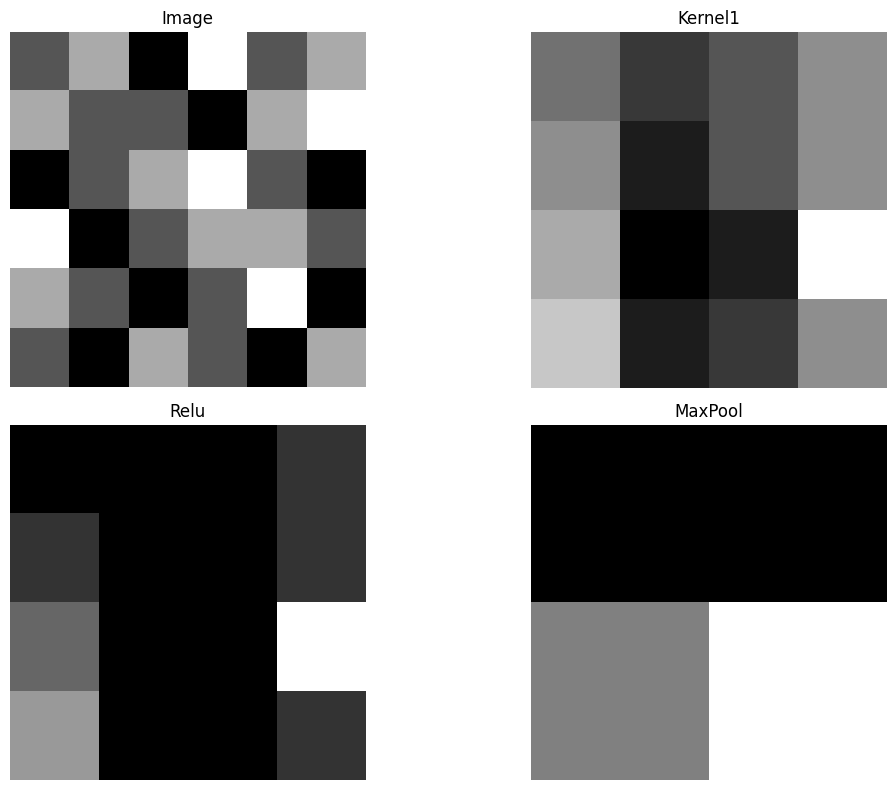

In [73]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 8))
steps = [("Image", image), ("Kernel1", output1), ("Relu", A1), ("MaxPool", pool1)]
for i, (title, img) in enumerate(steps):
    plt.subplot(2, 2, i + 1)
    plt.title(title)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Part 2

In [74]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=False)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=False)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

In [75]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc = nn.Linear(in_features=32*7*7, out_features=10)
    def forward(self, x):
        conv1 = self.conv1(x)
        relu1 = self.relu1(conv1)
        pool1 = self.pool1(relu1)

        conv2 = self.conv2(pool1)
        relu2 = self.relu2(conv2)
        pool2 = self.pool2(relu2)

        flat = pool2.view(pool2.size(0), -1)
        fc = self.fc(flat)

        return fc, conv1, relu1, pool1, conv2, relu2, pool2

device = torch.device("cpu")
model = SimpleCNN().to(device)
print("Summary: ")
summary(model, (1, 28, 28))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 5

model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs, _, _, _, _, _ , _, = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total * 100
    print("Epoch: {}, Loss: {:.4f}, Accuracy: {}".format(epoch + 1, epoch_loss, epoch_acc))


Summary: 
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           4,640
              ReLU-5           [-1, 32, 14, 14]               0
         MaxPool2d-6             [-1, 32, 7, 7]               0
            Linear-7                   [-1, 10]          15,690
Total params: 20,490
Trainable params: 20,490
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.32
Params size (MB): 0.08
Estimated Total Size (MB): 0.40
----------------------------------------------------------------
Epoch: 1, Loss: 11.2761, Accuracy: 94.87166666666667
Epoch: 2, Loss: 3.5296, Accuracy: 98.30666666

In [82]:
model.eval()
correct = 0
total = 0

misclassified_images = []
misclassified_labels = []
misclassified_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs, _, _, _, _, _, _ = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        for i in range(len(labels)):
            if predicted[i] != labels[i]:
                misclassified_images.append(images[i])
                misclassified_labels.append(labels[i])
                misclassified_predictions.append(predicted[i])

test_accuracy = correct / total * 100
print("Test Accuracy: {:.4f}".format(test_accuracy))

Test Accuracy: 99.0400


Visualizing feature maps for a test image with true label: 7


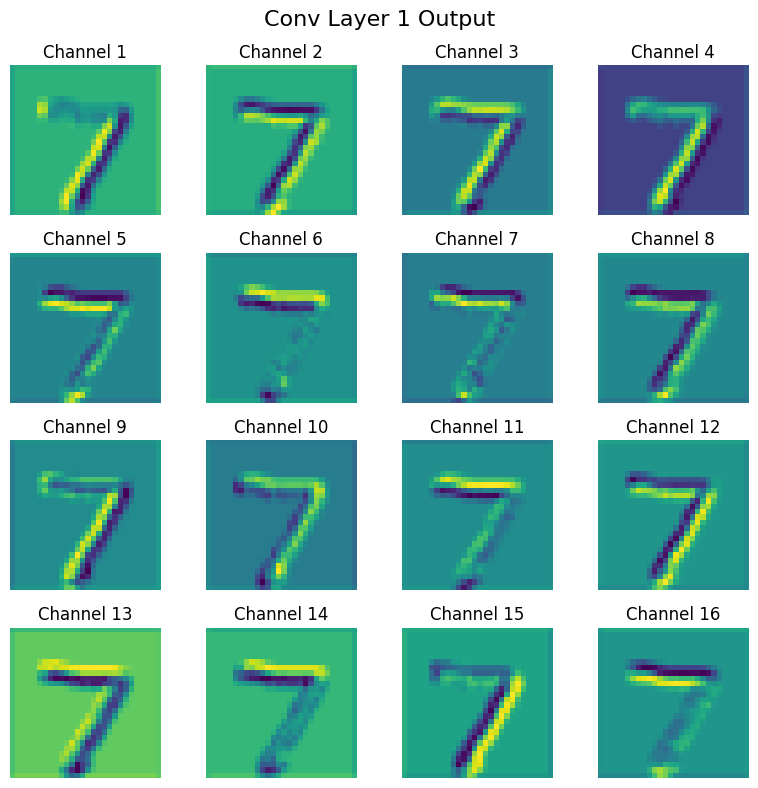

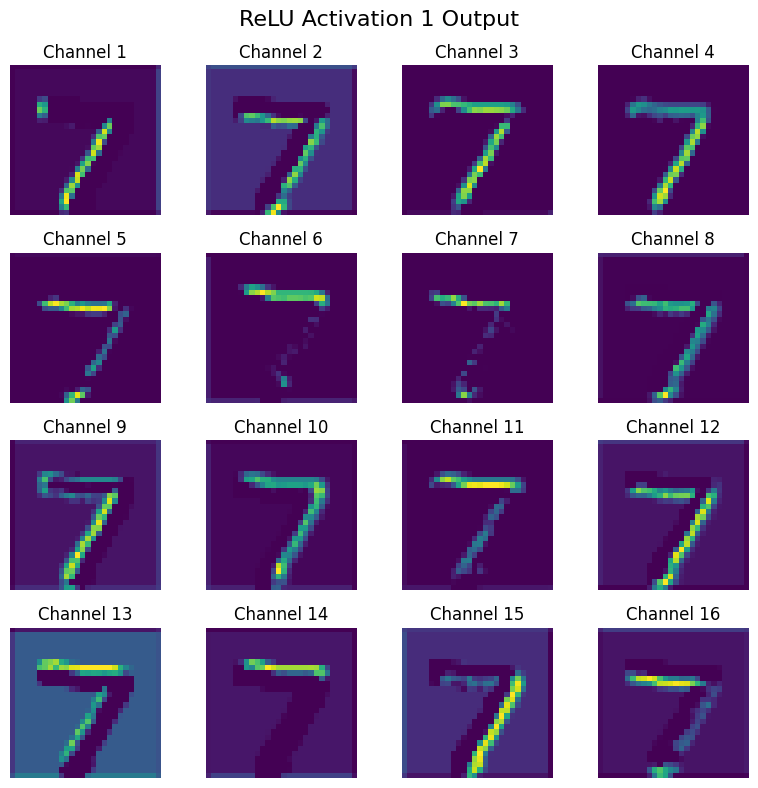

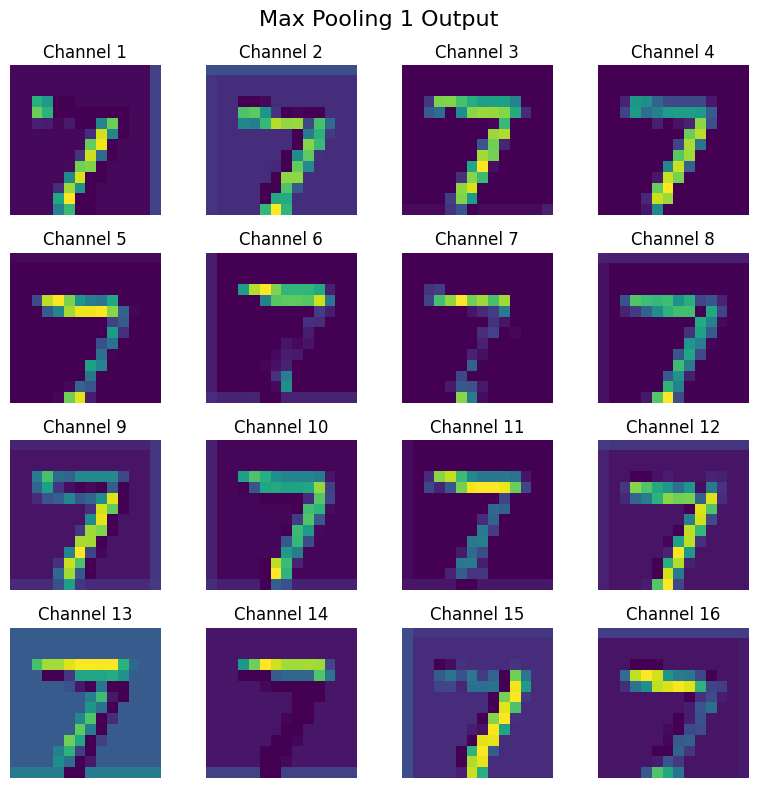

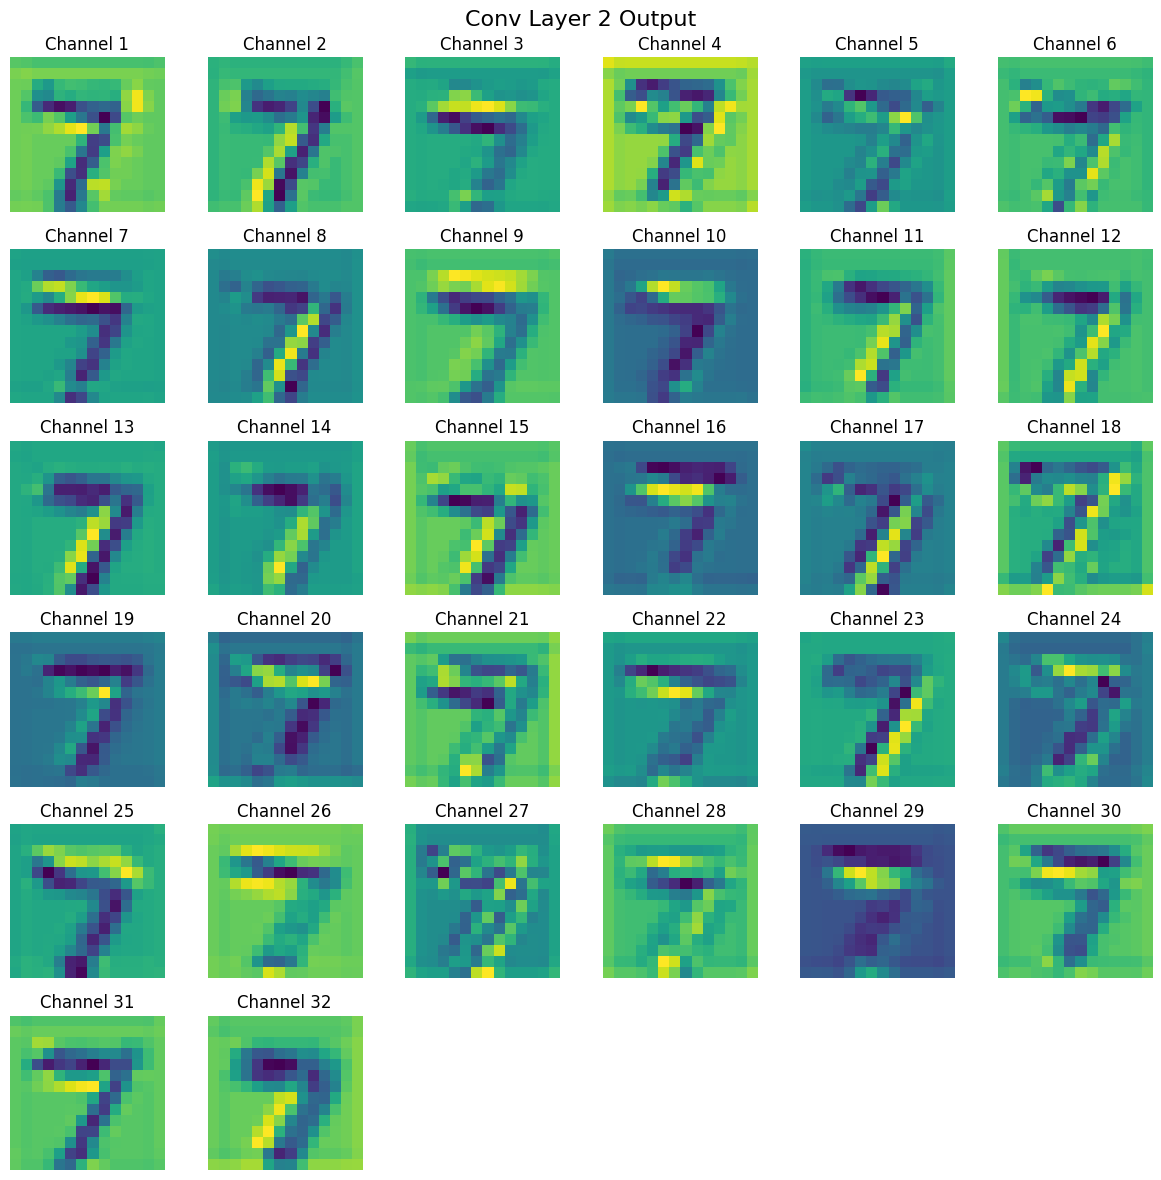

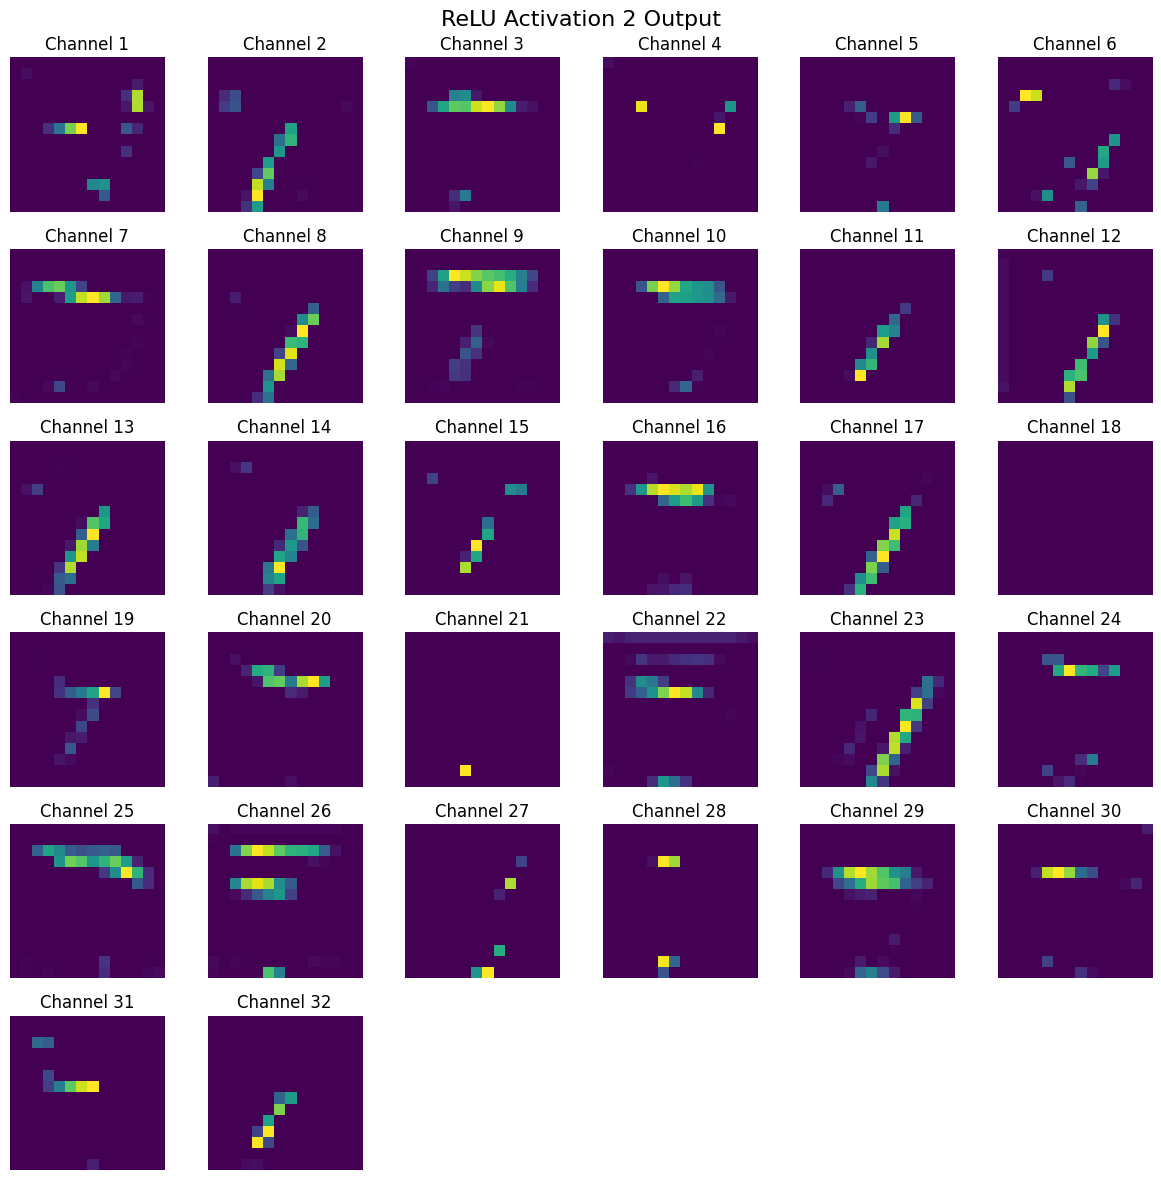

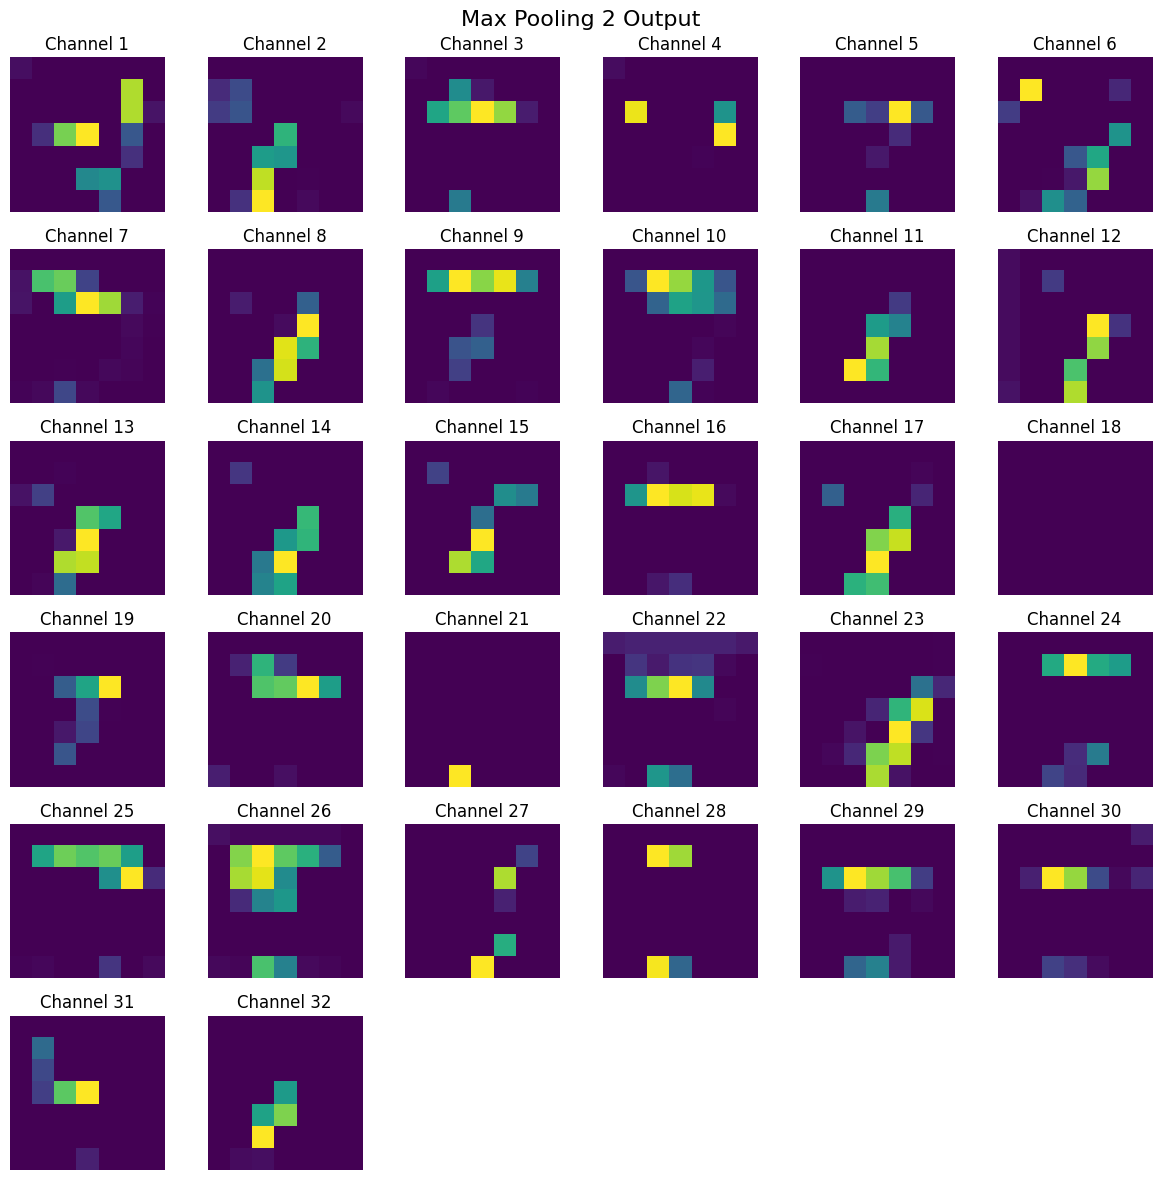

In [83]:
def visualize_feature_maps(model, image):
    model.eval()
    image = image.unsqueeze(0).to(device)
    with torch.no_grad():
        _, out_conv1, out_relu1, out_pool1, out_conv2, out_relu2, out_pool2 = model(image)

    def plot_features(features, title):
        features = features.cpu().squeeze(0)
        num_channels = features.shape[0]
        grid_cols = int(np.ceil(np.sqrt(num_channels)))
        grid_rows = int(np.ceil(num_channels / grid_cols))
        fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols*2, grid_rows*2))
        fig.suptitle(title, fontsize=16)
        axes = axes.flatten() if num_channels > 1 else [axes]

        for i in range(num_channels):
            axes[i].imshow(features[i].numpy(), cmap='viridis')
            axes[i].set_title(f"Channel {i+1}")
            axes[i].axis('off')

        for ax in axes[num_channels:]:
            ax.remove()

        plt.tight_layout()
        plt.show()

    plot_features(out_conv1, "Conv Layer 1 Output")
    plot_features(out_relu1, "ReLU Activation 1 Output")
    plot_features(out_pool1, "Max Pooling 1 Output")
    plot_features(out_conv2, "Conv Layer 2 Output")
    plot_features(out_relu2, "ReLU Activation 2 Output")
    plot_features(out_pool2, "Max Pooling 2 Output")

sample_image, sample_label = test_dataset[0]
print(f"Visualizing feature maps for a test image with true label: {sample_label}")
visualize_feature_maps(model, sample_image)


Displaying a few misclassified images:


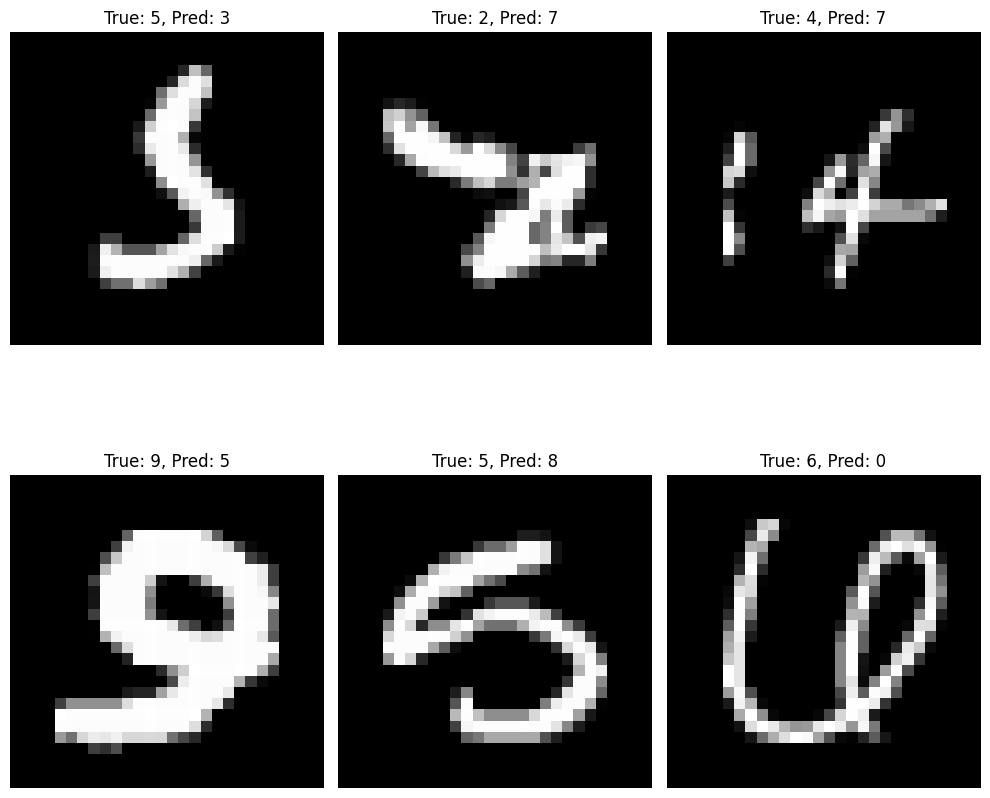

In [84]:
def plot_misclassified(images, true_labels, predicted_labels, num_images=6):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(2, 3, i+1)
        img = images[i].squeeze(0)
        plt.imshow(img.numpy(), cmap='gray')
        plt.title(f"True: {true_labels[i].item()}, Pred: {predicted_labels[i].item()}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

if misclassified_images:
    print("Displaying a few misclassified images:")
    plot_misclassified(misclassified_images, misclassified_labels, misclassified_predictions, num_images=6)